# Introduction
Solutions to potentials added to the infinite potential well can be represented as a linear combination of the energy eigenstates of the well, which form basis states as they are complete and orthogonal. The Hamiltonian can then be solved exactly through matrix mechanics with the only approximation being a truncation of the number of basis states. This can be used to solve complex problems, by embedding them into the infinite potential well. Find out more [here]().

In [ ]:
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg
from scipy.integrate import quad
from scipy.stats import cauchy

params = {'text.latex.preamble' : r'\usepackage{lmodern}',
          'text.usetex' : True,
          'font.size' : 11,
          'font.family' : 'lmodern',
          }
plt.rcParams.update(params) 

# Parameters

First, we define the parameters of the system we are using. Here, ${e\_ not}$ is the strength of the electric field, $a$ is the length of the potential well, $m$ is the mass of the particle, $q$ is the charge of the particle. All parameters here are in atomic units. A handy list of atomic units with values in SI included can be found [here](https://en.wikipedia.org/wiki/Hartree_atomic_units#Units).

However, by changing the value of $\hbar$ to $6.11*10^{-34}$ SI units can be used, however, this is not recommended as it may lead to precision issues. 

Lastly, $noOfStates$ is the number of basis states $N$ that will be used to expand the eigenstates of the new Hamiltonian.

In [ ]:
e_not = 0.1
a = 10
mass = 1  
q = 1   
hbar = 1
noOfStates = 200

def matprint(mat, fmt="g"):
    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x):
            print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
        print("")

# Setup

We define the energies and wavefunctions of our basis states, the eigenstates of the infinite potential well. We define a functions for the energy of the $n^{th}$ eigenstate as well as $\phi_n(x)$. We also store all of the energies up to $N$ that will come in handy later.

In [3]:
def E(n):
    return (n**2)*((np.pi)**2)/(2*mass*(a**2))
def phi(n,x):
    return np.sqrt(2/a)*np.sin(n*np.pi*x/a)

OriginalEnergies = np.zeros(noOfStates)
for i in range(noOfStates):
    OriginalEnergies[i] = E(i+1)

Here we define the matrix as a function of its coordinates. We have worked these out analytically beforehand. Then we use this to populate an $N \times N$ truncated matrix for the Hamiltonian.

In [4]:
def H(n, m):
    if (m == n):
        return E(n) + e_not*(a/2)
    elif ((m+n)%2 == 0):
        return 0
    else:
        return -e_not*(8*a/(np.pi**2))*(m*n/(m**2-n**2)**2)

In [5]:
vH = np.vectorize(H)
HMatrix = np.fromfunction(vH, (noOfStates+1, noOfStates+1))
HMatrix = HMatrix[1:noOfStates+1, 1:noOfStates+1]

# Finding Eigenstates and Eigenvalues
Next we obtain the eigenvalues and eigenvectors of the constructed matrix. We sort the eigenvalues, and their associated eigenvectors, in ascending order. The eigenvalues represent the energies of the new system, while the eigenvectors represent the corresponding eigenstates. Next, we will plot the resulting wavefunctions, proability densities and energy eigenstates.

In [6]:
def SortedEigen(A):
    eigenValues, eigenVectors = linalg.eigh(A)
    idx = np.argsort(eigenValues)
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]
    return (eigenValues, eigenVectors)

In [7]:
EnergiesH, EigenvectorsH = SortedEigen(HMatrix)

In [8]:
def psi(n, x):
    val = 0
    for i in range(noOfStates):
        val += EigenvectorsH[i,n-1]*phi(i+1,x)
    return val

In [9]:
#Calculating Matrix Elements:

f_not = 1

def V(x): 
    return (x-a/2)

def Helper(x,m,n):
    return phi(m,x)*V(x)*phi(n,x)

def Vmn(m,n):
    res, err = quad(Helper,0,a, args=(m,n,),limit=1000)
    if (abs(res)>=err):
        return res
    else:
        return 0

def DipoleCouplingStrength(n, m):
    if (m == n):
        return 0
    elif ((m+n)%2 == 0):
        return 0
    else:
        return -f_not*(8*a/(np.pi**2))*(m*n/(m**2-n**2)**2)
    
vdcs = np.vectorize(DipoleCouplingStrength)
vdcscomp = np.vectorize(Vmn)


In [10]:
def Helper2(x,m,n):
    return psi(m,x)*V(x)*psi(n,x)

def Vmn2(m,n):
    res, err = quad(Helper2,0,a, args=(m,n,),limit=1000)
    if (abs(res)>=err):
        return res
    else:
        return 0

In [11]:
length = 10


DipoleStrengthMatrix = np.zeros((length,length))
for i in range(1,length+1):
    for j in range (1,length+1):
        DipoleStrengthMatrix[i-1,j-1] = DipoleCouplingStrength(i,j)


DipoleStrengthMatrixComp = np.fromfunction(vdcscomp, ((length +1), (length+1)))
DipoleStrengthMatrixComp = DipoleStrengthMatrixComp[1:(length + 1), 1:(length + 1)]

DipoleStrengthMatrixPerturb = np.zeros((length,length))
for i in range(1,length+1):
    for j in range (1,length+1):
        DipoleStrengthMatrixPerturb[i-1,j-1] = Vmn2(i,j)

        
DipoleStrengthMatrix = np.absolute(DipoleStrengthMatrix)
DipoleStrengthMatrixPerturb = np.absolute(DipoleStrengthMatrixPerturb)

DipoleStrengthMatrixCompDebye = DipoleStrengthMatrixComp*2.52


DipoleStrengthMatrixDebye = (DipoleStrengthMatrix)*2.52
DipoleStrengthMatrixPerturbDebye = (DipoleStrengthMatrixPerturb)*2.52

In [12]:
matprint(DipoleStrengthMatrixDebye)

        0    4.53919          0  0.363135         0  0.100047         0  0.0411718          0  0.0208411  
  4.53919          0    4.90232         0  0.463183         0  0.141219          0  0.0620129          0  
        0    4.90232          0   5.00237         0  0.504354         0    0.16206          0  0.0739996  
 0.363135          0    5.00237         0   5.04354         0  0.525195          0   0.174047          0  
        0   0.463183          0   5.04354         0   5.06438         0   0.537182          0   0.181568  
 0.100047          0   0.504354         0   5.06438         0   5.07637          0   0.544703          0  
        0   0.141219          0  0.525195         0   5.07637         0    5.08389          0   0.549729  
0.0411718          0    0.16206         0  0.537182         0   5.08389          0    5.08892          0  
        0  0.0620129          0  0.174047         0  0.544703         0    5.08892          0    5.09244  
0.0208411          0  0.0739996      

In [14]:
matprint(DipoleStrengthMatrixPerturbDebye)

  5.88457    2.82577   0.864381   0.430308    0.23315   0.143202  0.0898046  0.0623784  0.0430376  0.0323439  
  2.82577    1.05206    4.17341   0.851395   0.447301    0.17457   0.135974  0.0644483  0.0592369  0.0309791  
 0.864381    4.17341    1.18568    4.79943   0.497279   0.476693  0.0980436   0.150634   0.036664   0.068127  
 0.430308   0.851395    4.79943    1.14853    4.99215   0.291358   0.514139   0.058412   0.169085  0.0221504  
  0.23315   0.447301   0.497279    4.99215   0.801034    5.04967   0.193229   0.533228  0.0395214   0.179634  
 0.143202    0.17457   0.476693   0.291358    5.04967   0.569158    5.07118   0.138694   0.543096  0.0288681  
0.0898046   0.135974  0.0980436   0.514139   0.193229    5.07118   0.422515    5.08174   0.104773   0.548992  
0.0623784  0.0644483   0.150634   0.058412   0.533228   0.138694    5.08174   0.325496    5.08791  0.0820843  
0.0430376  0.0592369   0.036664   0.169085  0.0395214   0.543096   0.104773    5.08791   0.258263    5.09193  
0

In [15]:
np.fill_diagonal(DipoleStrengthMatrixPerturbDebye, 0)

In [16]:
matprint(DipoleStrengthMatrixPerturbDebye)

        0    2.82577   0.864381   0.430308    0.23315   0.143202  0.0898046  0.0623784  0.0430376  0.0323439  
  2.82577          0    4.17341   0.851395   0.447301    0.17457   0.135974  0.0644483  0.0592369  0.0309791  
 0.864381    4.17341          0    4.79943   0.497279   0.476693  0.0980436   0.150634   0.036664   0.068127  
 0.430308   0.851395    4.79943          0    4.99215   0.291358   0.514139   0.058412   0.169085  0.0221504  
  0.23315   0.447301   0.497279    4.99215          0    5.04967   0.193229   0.533228  0.0395214   0.179634  
 0.143202    0.17457   0.476693   0.291358    5.04967          0    5.07118   0.138694   0.543096  0.0288681  
0.0898046   0.135974  0.0980436   0.514139   0.193229    5.07118          0    5.08174   0.104773   0.548992  
0.0623784  0.0644483   0.150634   0.058412   0.533228   0.138694    5.08174          0    5.08791  0.0820843  
0.0430376  0.0592369   0.036664   0.169085  0.0395214   0.543096   0.104773    5.08791          0    5.09193  
0

In [18]:
def deviationOriginalWell(x,n):
    return phi(n,x)*x**2*phi(n,x)

def position(x,n):
    return psi(n,x)*x*psi(n,x)

def deviation(x,n):
    return psi(n,x)*x**2*psi(n,x)

def positionexpectation(n):
    res, err = quad(position,0,a, args=(n,),limit=1000)
    if (abs(res)>=err):
        return res
    else:
        return 0
    
def standardDeviation(n):
    pos, err = quad(position,0,a, args=(n,),limit=1000)
    dev,err = quad(deviation, 0,a, args =(n,), limit=1000)
    if (abs(dev)>=err):
        return np.sqrt(dev - pos**2)
    else:
        return 0
def standardDeviationOriginalWell(n):
    dev,err = quad(deviationOriginalWell, 0,a, args =(n,), limit=1000)
    if (abs(dev)>=err):
        return np.sqrt(dev - 5**2)
    else:
        return 0

[2.66485369 4.58251615 5.47050942 5.45576749 5.31787059 5.22585654
 5.16766462 5.12916523 5.10248535 5.08326521 5.06897135 5.05805741
 5.04953804 5.04276182 5.03728438 5.03279425 5.02906793 5.0259417
 5.02329343 5.02103051 5.01908172 5.01739155 5.0159162  5.01462079
 5.01347721 5.01246266 5.01155843 5.0107491  5.01002185 5.00936594]


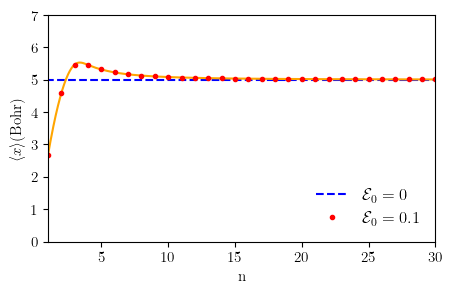

In [19]:
from scipy.interpolate import make_interp_spline, BSpline

j = 30

x = np.linspace(1,j,j)
x2 = np.linspace(0,j,j+1)

fig = plt.figure(figsize=(5,3), dpi= 100)
ax = fig.add_subplot(1, 1, 1)
y = np.zeros(len(x))
y2 = np.zeros(len(x2))

ax.plot(x2,y2+5,'--',color='blue', label="$\mathcal{E}_0 = 0$")

for i in range (1, j+1):
    y[i-1] = (positionexpectation(i))

print(y)
xnew = np.linspace(1,j,1000)
spl = make_interp_spline(x,y,k=3)
position_smooth = spl(xnew)
ax.plot(xnew,position_smooth,color="orange")

ax.plot(x, y,'.r',label="$\mathcal{E}_0 = %g$"%e_not)
ax.set_xlabel('n')
ax.set_ylabel(r'$\langle x \rangle$(Bohr)')
ax.set_xlim(1,j)
ax.set_ylim(0,7)


ax.legend(loc = 'lower right', fontsize=12, fancybox=True, framealpha=0.0)

fig.savefig(r"./graphics/figure7.pdf",bbox_inches='tight')

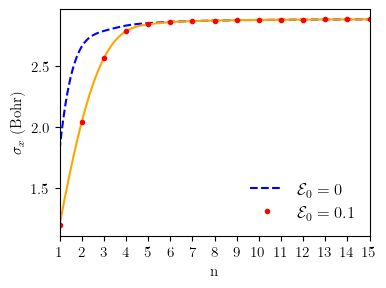

In [20]:
from scipy.interpolate import make_interp_spline, BSpline

x = np.linspace(1,15,15)
fig = plt.figure(figsize=(4,3), dpi= 100)
ax = fig.add_subplot(1, 1, 1)
y = np.zeros(len(x))
z = np.zeros(len(x))

for i in range (1, 16):
    z[i-1] = (standardDeviationOriginalWell(i))
xnew = np.linspace(1,15,1000)
spl = make_interp_spline(x,z,k=5)
deviation_smooth = spl(xnew)
ax.plot(xnew,deviation_smooth,"--",color="blue",label="$\mathcal{E}_0 = 0$")



for i in range (1, 16):
    y[i-1] = (standardDeviation(i))

xnew = np.linspace(1,15,1000)
spl = make_interp_spline(x,y,k=5)
deviation2_smooth = spl(xnew)
ax.plot(xnew,deviation2_smooth,color="orange")
ax.plot(x, y,'.r',label="$\mathcal{E}_0 = %g$"%e_not)

ax.set_xlabel('n')
ax.set_ylabel(r'$\sigma_x$ (Bohr)')
ax.set_xlim(1,15)
ax.set_xticks(x)


ax.legend(loc = 'lower right', fontsize=12, fancybox=True, framealpha=0.0)

fig.savefig(r"./graphics/figure12.pdf",bbox_inches='tight')

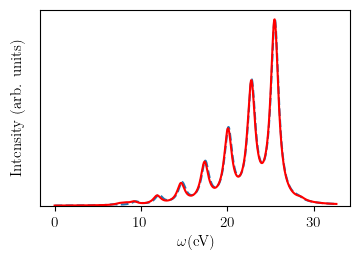

In [22]:
values  = np.zeros(shape=(length**2,2))
counter = 0
epsilon_not = 1
c = 1

length = 10

for i in range(1, length+1):
    for j in range(1, length+1):
        if i>j:
            omega = abs(OriginalEnergies[i-1] - OriginalEnergies[j-1])   
            #print(omega)
            I = ((DipoleStrengthMatrixDebye[i-1,j-1]**2)*(omega**4))/(3*(np.pi)*epsilon_not*(c**3))
            values[counter:counter+1] = [omega, I]
            counter += 1
    
values = values[0:counter]
#print(values)

values2  = np.zeros(shape=(length**2,2))
counter2 = 0

for i in range(1, length+1):
    for j in range(1, length+1):
        if i>j:
            omega = abs(EnergiesH[i-1] - EnergiesH[j-1])   
            #print(omega)
            I = ((DipoleStrengthMatrixDebye[i-1,j-1]**2)*(omega**4))/(3*(np.pi)*epsilon_not*(c**3))
            values2[counter2:counter2+1] = [omega, I]
            counter2 += 1
    
values2 = values2[0:counter2]
#print(values2)

x = np.linspace(0,1.2, 1000)
y  = np.zeros(len(x))
y2  = np.zeros(len(x))


for k in range(len(values)):
    y += cauchy.pdf(x, values[k,0],0.02)*values[k,1]

for k in range(len(values2)):
    y2 += cauchy.pdf(x, values2[k,0],0.02)*values2[k,1]


xev = 27.2114 * x

fig = plt.figure(figsize=(4,2.6), dpi= 100)
ax = fig.add_subplot(1, 1, 1)
#ax.plot(values[:,:1],values[:,1:],'x')
#ax.plot(values[:,:1]*27.2114,values[:,1:],'x')
#ax.plot(values2[:,:1]*27.2114,values2[:,1:],'x',color='red')
#ax.plot(x, (cauchy.pdf(x, values[0,0],0.01)*values[0,1])/20)
ax.plot(xev, y,'--')
ax.plot(xev,y2, 'r')
ax.set_xlabel(r'$$\omega \textnormal{(eV)}$$')
ax.set_ylabel('Intensity (arb. units)')
ax.set_yticklabels([])
ax.set_ylim(0,)
ax.yaxis.set_ticks_position('none')
fig.savefig(r"./graphics/10states2.pdf",bbox_inches='tight')
